# Predicting Newsletter Subscription Using Age and Hours Played

## Introduction

A UBC Computer Science research group led by Frank Wood is collecting user and system information from the PLAIcraft server. This research group's overarching goal is to "advance the frontiers of artificial intelligence through groundbreaking work in generative modelling, reinforcement learning, probabilistic programming, and Bayesian inference" (PLAI, 2024). With the PLAICraft, they aim to collect data from players on Minecraft gameplay to use to train NPC agents to play like real players by being able to “respond sensibly in video and audio perceptual environments” (Smith, 2025). Our group project will help contribute to their goal by examining the possible correlation between age characteristics and playtime behaviours to subscription status, to find ways to encourage players to subscribe to the newspaper through the help of the trained NPC agents.

### Question
<p>We will be addressing question 1:</p><p><em>What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?</em></p>

To explore this, our question is:
<strong>Can age and hours played predict if a player will subscribe to a game newsletter?</strong></em><p>

This question will be answered using the `players.csv` dataset. The dataset contains information about the players, which includes personal details such as their name, email, gender and age, alongside their experience levels, hours played and whether they are subscribed to the newsletter or not.


`players.csv`consists of user data with 196 observations and 7 variables:

|<strong>Variable         | Data Type | Variable Definition</strong>                       |
|:------------------------|:----------|:---------------------------------------------------|
| `experience`            | chr       | Player's experience level                          |
| `subscribe`             | lgl       | If player has subscribed to the game newsletter    |
| `hashedEmail`           | chr       | Player's unique hashed email                       |
| `played_hours`          | dbl       | Hours  player has played on the PLAICraft server   |
| `name`                  | chr       | Player's name                                      |
| `gender`                | chr       | Player's gender                                    |
| `Age`                   | dbl       | Player's age                                       |

The purpose of this project will be to address whether age characteristics and playtime hours can effectively predict the newsletter subscription status of a player, using the ages and playtime hours of subscribing and non-subscribing player types in the dataset. 



## Methods & Results

In [1]:
# We will set a seed to ensure that our data analysis is reproducible
set.seed(2222)

# Run cell to import all libraries
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(themis)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

#### Loading and Wrangling the Dataset
As we are only working with `subscribe`, `Age` and `played_hours` in this analysis, we will only select these variables in our data wrangling.

In [2]:
# Loading in the data
players_raw <- read_csv("https://raw.githubusercontent.com/echen504/dsci-100-25w2-grp29/refs/heads/main/players.csv")

# Wrangling the dataset that will be used in this project
players <- players_raw |>
    select(subscribe, played_hours, Age) |>
    mutate(subscribe = as_factor(subscribe)) |>
    mutate(subscribe = fct_recode(subscribe, "Subscriber" = "TRUE", "Non-Subscriber" = "FALSE")) 
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
Subscriber,30.3,9
Subscriber,3.8,17
Non-Subscriber,0.0,17
Subscriber,0.7,21
Subscriber,0.1,21
Subscriber,0.0,17


#### Summary Statistics of the Dataset

In [3]:
players_max <- players |>
    select(played_hours, Age) |>
    map_df(max, na.rm = TRUE)

players_min <- players |>
    select(played_hours, Age) |>
    map_df(min, na.rm = TRUE)

players_avg <- players |>
    select(played_hours, Age) |>
    map_df(mean, na.rm = TRUE)

players_median <- players |>
    select(played_hours, Age) |>
    map_df(median, na.rm = TRUE)

|Summary Statistic| Hours Played | Age    |
|:---------------:|:------------:|:------:|
|Max              |223.1         |50      |
|Min              |0             |8       |
|Mean             |5.845918      |20.52062|
|Median           |0.1           |19      |

#### Visualizing the Exploratory Data

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


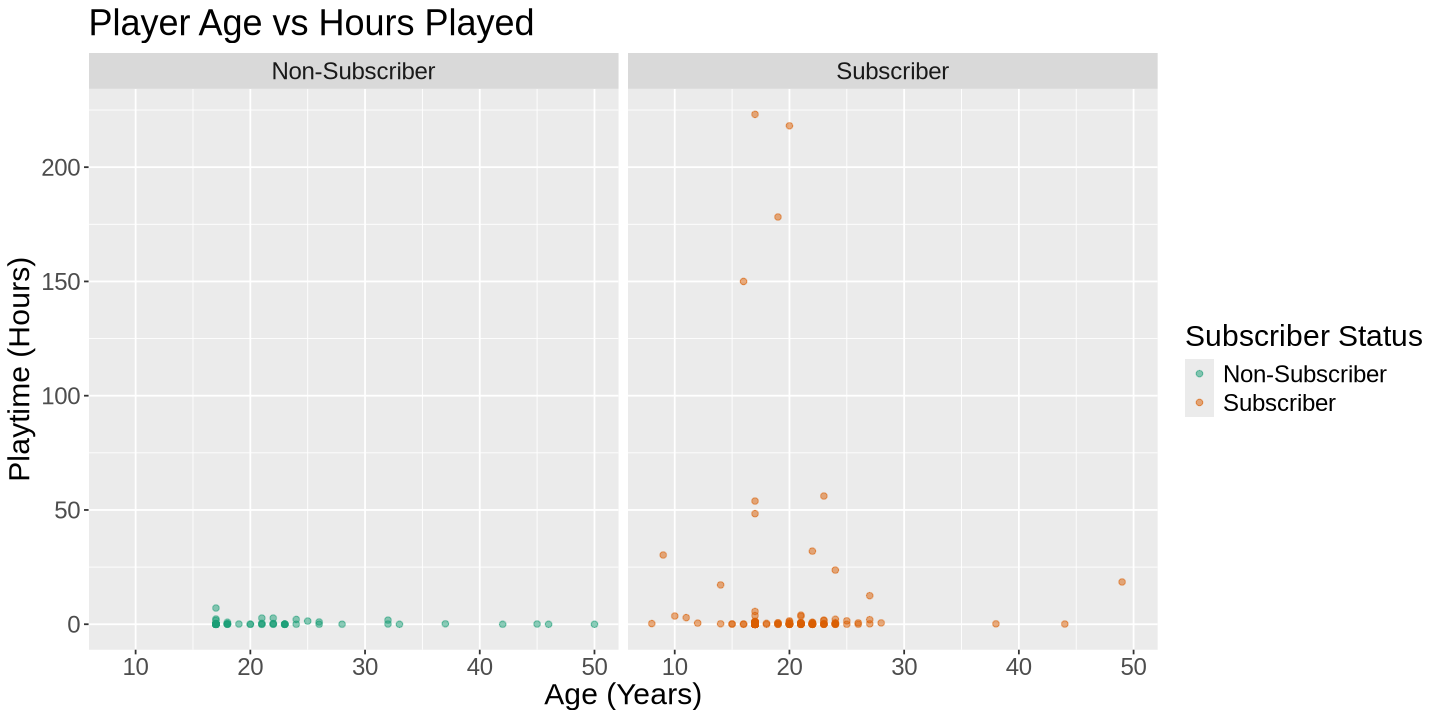

In [4]:
options(repr.plot.height = 6, repr.plot.width = 12)

# Visualizing player age vs. hours played in a scatterplot
players_plot <- players |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.5) +
    labs(x = "Age (Years)",
         y = "Playtime (Hours)",
         title = "Player Age vs Hours Played",
         color = "Subscriber Status") +
    theme(text = element_text(size = 18)) +
    scale_color_brewer(palette = "Dark2") +
    facet_grid(cols = vars(subscribe))
players_plot

<strong>Figure 1:</strong> Scatterplot of player age vs hours played, separated by subscriber class. 

### Data Analysis

We will be using a <strong>K-nearest neighbours classification</strong> to predict the `subscribe` class using predictor variables `Age` and `played_hours`.

##### We first let R randomly split the data into a 75/25 training and testing set.

In [5]:
# players <- players |>
# filter(!is.na(Age))

players_split <- initial_split(players, prop = 0.75, strata = subscribe)
players_training <- training(players_split) 
players_testing <- testing(players_split)

head(players_training)
head(players_testing)

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
Non-Subscriber,0.0,17
Non-Subscriber,0.1,17
Non-Subscriber,0.1,18
Non-Subscriber,1.4,25
Non-Subscriber,0.0,23
Non-Subscriber,0.9,18


subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
Non-Subscriber,0.0,21
Subscriber,0.0,22
Subscriber,1.6,23
Subscriber,1.5,25
Non-Subscriber,0.0,22
Non-Subscriber,0.0,23


##### After analyzing the wrangled training set, we noticed that some age values are NA. We will filter these out. 

In [6]:
players_training <- players_training |> filter(!is.na(Age))

##### Now, we will pre-process and standardize the training set data using the recipe function.
In the standardized recipe, we will specify that:
- `subscribe` is the response variable 
- `Age` and `played_hours` are the predictors
##### We will also build our K-Nearest Neighbours Classification model and tune it.

In [7]:
# Creating our recipe and standardizing the data
players_recipe <- recipe(subscribe ~ ., data = players_training) |>
    step_normalize(all_predictors()) 

# Tuning our K-NN classification model
data_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

##### Next, we will perform a 5-fold cross-validation on the training set to choose the K-value with the best accuracy estimate. 
To do this, we will: 
1. Split the training set into 5 folds using vfold_cv
2. Create a tibble object with a sequence of possible K-values from 1 to 20 (stepping by 2)
3. Fit the K-NN model and recipe into a workflow
<ol>
  <li> Use tune_grid to fit the model into each possible K-value in the sequence created in step 2 </li>
  <li> Utilize collect_metrics to compute the mean and standard error of the classifier's validation accuracy across all folds
    <ul>

In [8]:
# Splitting the training set data into 5 folds
data_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)

# Creating a sequence of potential K-values
knn_grid <- tibble(neighbors = seq(from = 1, to = 20, by = 2))

# Fitting the K-NN model and recipe into the workflow
data_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(data_spec) |>
    tune_grid(resamples = data_vfold, grid = knn_grid)|> 
    collect_metrics() 
head(data_fit)

accuracies <- data_fit |>
    filter(.metric == "accuracy")

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4889491,5,0.02319200,Preprocessor1_Model01
1,roc_auc,binary,0.5128788,5,0.03257138,Preprocessor1_Model01
3,accuracy,binary,0.5513136,5,0.03983715,Preprocessor1_Model02
3,roc_auc,binary,0.5357916,5,0.06057452,Preprocessor1_Model02
5,accuracy,binary,0.5653366,5,0.03567327,Preprocessor1_Model03
5,roc_auc,binary,0.5252783,5,0.06346370,Preprocessor1_Model03


##### We will now decide on the best K-value by plotting Accuracy Estimate vs. Neighbors. 
The K-value from 1 to 20 with the highest accuracy estimation will be selected.

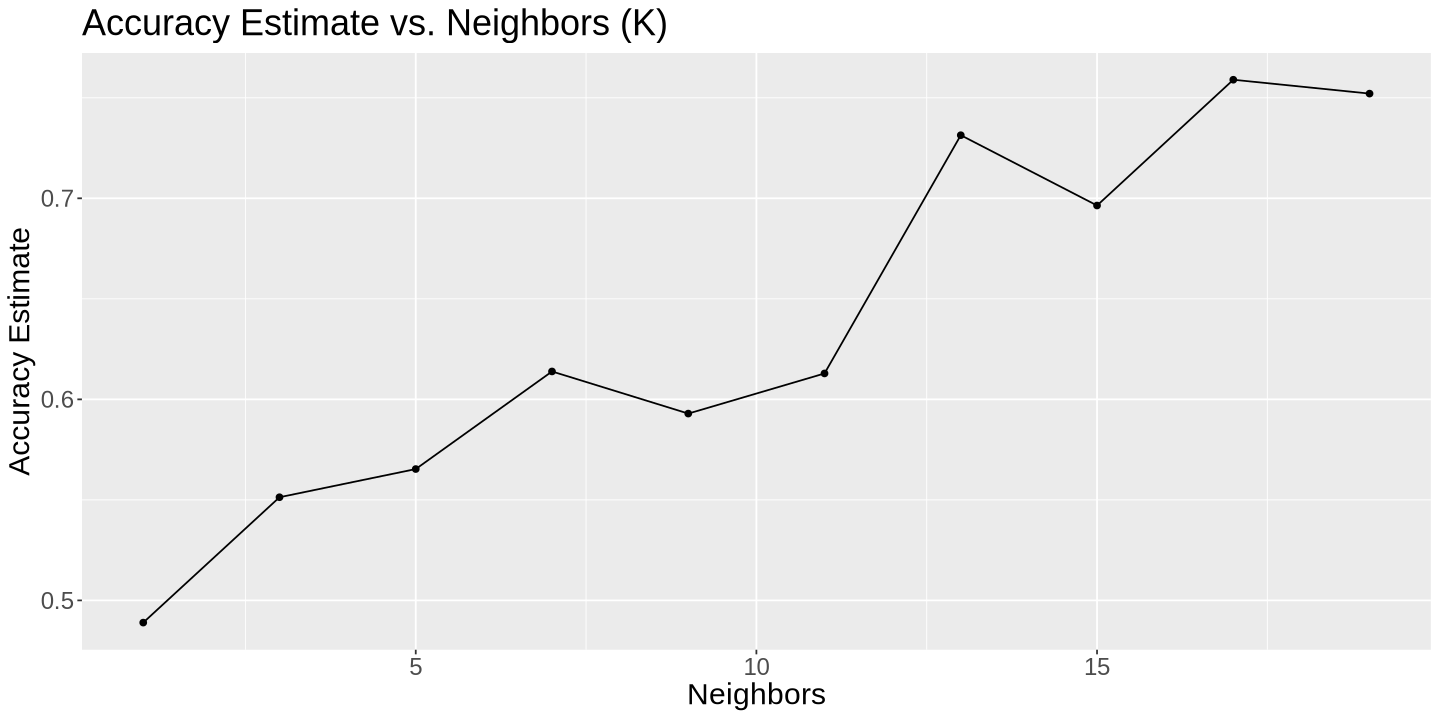

In [9]:
options(repr.plot.height = 6, repr.plot.width = 12)

# Accuracy Estimate vs. Neighbours (K-value) Visualization
cross_val_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimate vs. Neighbors (K)") +
    theme(text = element_text(size = 18))
cross_val_plot

<strong> Figure 2:</strong> Accuracy vs. K Plot to select the best K-value with the highest accuracy estimate

In [10]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 17

##### From the Figure 2 and `best_k` analysis above, we have concluded that K = 17 is the best K-value to use in the K-NN model. 

We will now build our K-NN Classification model and fit it into the workflow using the best k.

In [11]:
# Creating a K-NN model using K = 17
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
    set_engine("kknn") |>
    set_mode("classification")

# Fitting the new model into the workflow
players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_training)
players_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_normalize()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(17,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2827586
Best kernel: rectangular
Best k: 17

In [12]:
players_predictions <- predict(players_fit, players_testing) |>
    bind_cols(players_testing)
head(players_predictions)

players_metrics <- players_predictions|>
    metrics(truth = subscribe, estimate = .pred_class)
players_metrics

players_conf_mat <- players_predictions |>
    conf_mat(truth = subscribe , estimate = .pred_class)
players_conf_mat

# player_recall <- players_predictions |>
#     recall(truth =subscribe, estimate = .pred_class, event_levels = "first")

# player_precision <- players_predictions |>
#     precision(truth =subscribe, estimate = .pred_class, event_levels = "first")

# player_accuracy <- players_predictions |>
#     accuracy(truth =subscribe, estimate = .pred_class, event_levels = "first")

# player_metrics <- tibble(
#     accuracy = player_accuracy |> select(.estimate) |> pull(),
#     recall = player_recall |> select(.estimate) |> pull(),
#     precision = player_precision |> select(.estimate) |> pull()
#                         )
# player_metrics

.pred_class,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
Subscriber,Non-Subscriber,0.0,21
Subscriber,Subscriber,0.0,22
Subscriber,Subscriber,1.6,23
Subscriber,Subscriber,1.5,25
Subscriber,Non-Subscriber,0.0,22
Subscriber,Non-Subscriber,0.0,23


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.71428571
kap,binary,-0.03939394


                Truth
Prediction       Non-Subscriber Subscriber
  Non-Subscriber              0          1
  Subscriber                 13         35

## Limitations

#### Class Imbalance 
<p>The variable subscribe has more observations for individuals who are subscribed compared to individuals who are not subscribed (## vs ##). Our model performs classification by using the mode among the nearest neighbours. An imbalanced data set may cause the model to predict the class with more observations more often, showing bias towards the majority class. Subscribed is the majority class in this case.</p>

#### Outliers
<p>Most of the observations for the variables Age and played_hours lie in the ______ range. However, outliers in the _____ range can lead to incorrect classifications. Since our model relies on Euclidean distance calculations to determine the K-nearest neighbour, outliers may distort the calculated distances and make similar observations seem further apart than they actually are.</p>  

#### Sample Size
<p>Another possible limitation is the small sample size in comparison to the magnitude of K. This can lead to a possible underfitting of the data, since it can make the classification less specific and more general. A small sample size can also make the report lose its validity through its limited chance of representing the actual population, This can also lead  to a possible overfitting of the classification model - it could focus too much on each individual point and fail to look at the data overall, which makes it difficult to make generalized conclusions. </p> 




## References 

<p>Pacific Laboratory for Artificial Intelligence (PLAI). Pacific Laboratory for Artificial 
    Intelligence. (2024, December 5). https://plai.cs.ubc.ca/</p> 
<p>Smith, A. (2025, January 21). Plaicraft.ai launch. Pacific Laboratory for Artificial 
    Intelligence. https://plai.cs.ubc.ca/2023/09/27/plaicraft/  </p> 
